## Intro
A machine learning project I am currently working on requires the use of a model which can make predictions in realtime, running on basic consumer hardware (ie. no fancy gpus).

In this notebook I will compare the time taken for various different deep learning architectures to produce predictions from the same set of data. The aim here is to get a feel for how signifcant a penalty we have to pay (in terms of time taken to produce predictions), in order to use more complex models which might better fit the data.

Training the models and assessing their accuracy is out of scope for this investigation, we are only concerned with the model's suitability for realtime applications here.

There are indeed many architectures available which are capable of producing predictions faster than those used in deep learning (such as polynomial regression, random forests, etc), but these will not be explored here. A previous investigation has found that these models severely underfit the data used in this project, so have been ruled out.

### Some context
_I assume many readers are not so interested in the details and are just here to see some pretty performance graphs, if that's you then feel free to skip ahead. Otherwise, this section might answer some additional questions you have._

The project which this investigation is part of aims to develop machine learning models which can process audio in realtime. Audio is most commonly sampled at between 44.1kHZ and 192kHz (ie. 1 second of audio would give 44100 samples, or 192000 samples). In realtime systems these samples will often be delivered in buffers, which are most commonly groups of somewhere between 32 and 1024 samples. Each buffer needs to be processed in only a few milliseconds, else the buffer is missed and playback temporarily stops.

In the case of this project, we know virtually nothing about the system which a user might be running the model on. It could be a workstation with 2 GPUs and 12 CPU cores, or it could be a 5 year old laptop with an Intel Celeron, either way the model still needs to deliver the required performance.

Because of these constraints we'll be avoiding deep or complex models won't be able to provide the required performance

### Time domain vs Frequency domain
In this analysis we'll start by working in the time domain (ie. just working with the raw samples). In a later notebook I may also explore the frequency domain as a form of feature engineering by performing an [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform), and this may allow the models to perform better.

### Imports/Setup

In [1]:
%matplotlib inline

In [2]:
import time
from IPython.core.display import clear_output

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
import tensorflow as tf

### Generating Data
Before we start building our models, we should probably create the data to test them with.

Normally the model would be fed an audio signal, but since we're only worried about the prediction times we'll generate some random data.

The input shape is [1000000, 100], so that's 1 million instances, with 100 features. The output data shape is [1000000], ie. one value for each instance. The inputs and outputs are all 32-bit float values.

Each instance represents a single sample in the audio stream, where the first feature is the value of the input sample, the second feature is the value of the sample which preceded it in the audio stream, the third feature is the value of the sample which preceded the sample used in the second feature, etc. This looks something like the below:

|F0 |F1 |F2 |...|F100|
|:-:|:-:|:-:|:-:|:--:|
|0.1|0  |0  |   |0   |
|0.2|0.1|0  |   |0   |
|0.1|0.2|0.1|   |0   |

The output values are the output samples that correspond to the input sample (F0).

In [5]:
X = np.random.rand(1000000, 100)
y = np.random.rand(1000000)

We'll now define some functions that'll help us plot the prediction times.

In [6]:
def plotTimes(title, xLabel, xValues, yLabel, yValues, times, invertY=False):
    """Plots a 3D plot of the prediction times"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xValues, yValues, times, cmap=matplotlib.cm.coolwarm)
    plt.title(title)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_zlabel("Prediction time (s)")
    
    if invertY:
        ax.invert_yaxis()
        
    plt.show()
    
def runPredictions(times, graphFunc, *args):
    """
    Populates a matrix of prediction times.
    times        Must be a 2 dimensional matrix presized to the expected size of the results.
    graphFunc    Is the function to be used to build and run a single graph. It should return
                 the time taken for the model to produce a prediction.
    args         Arguments to be passed to graphFunc. Each argument must be a tuple of
                 (arg, bool), where arg is the parameter to be passed to graphFunc, and bool
                 should be True if the arg is a meshgrid which needs to be indexed by
                 [row][col] before passing to graphFunc
    """
            
    completed = 0
    
    for row in range(times.shape[0]):
        for col in range(times.shape[1]):
            # Parse the args to work out which we need to index
            argsList = []
            for arg in args:
                if arg[1]:
                    argsList.append(arg[0][row][col])
                else:
                    argsList.append(arg[0])
            
            times[row, col] = graphFunc(*argsList)
            
            completed += 1
            clear_output()
            print(completed, "/", times.size)
            
    return times

### Feedforward Networks

First we'll start off by building simple feedforward networks, which should be some of the fastest, and see how they slow down as more hidden layers and neurons are added. Below I've defined a function which can build graphs and return the time it took that graph to make predictions.

In [7]:
def buildAndRunFeedforward(X, numHiddenLayers, numHiddenUnits):
    """Builds a feed forward neural network and returns the time taken to produce predictions"""
    tf.reset_default_graph()
    
    with tf.name_scope("init"):
        X_in = tf.placeholder(shape=(None, X.shape[1]), dtype=tf.float32, name="X_in")

    with tf.name_scope("dnn"):
        
        lastHiddenLayer = None
        for layerNumber in range(numHiddenLayers):
            layerInput = X_in if lastHiddenLayer is None else lastHiddenLayer
            
            lastHiddenLayer = tf.layers.dense(layerInput,
                                              units=numHiddenUnits,
                                              activation=tf.nn.relu)
            
        logits = tf.layers.dense(lastHiddenLayer, units=1, name="outputs")

    with tf.name_scope("init"):
        init = tf.global_variables_initializer()

    with tf.Session() as sess:
        init.run()

        startTime = time.time()
        logits.eval(feed_dict={X_in: X})
        predictionTime = time.time() - startTime
        
    return predictionTime

Now we'll use the function to plot a graph of the times

In [8]:
# Choose the combinations of number of layers and number of neurons to try out
layers = np.linspace(1, 10, 10, dtype=np.int16)
neurons = np.linspace(100, 600, 10, dtype=np.int16)
layers, neurons = np.meshgrid(layers, neurons)

times = np.zeros((layers.shape))
times = runPredictions(times, buildAndRunFeedforward, (X, False), (layers, True), (neurons, True))

print(times)

100 / 100
[[  0.856534     0.98955798   1.32739711   1.64241385   1.87910891
    2.17272305   2.47026801   2.87918687   3.14806986   3.38938189]
 [  0.76959515   1.39807582   1.99335313   2.35189891   2.91419601
    3.54412508   3.99597311   4.73204613   5.29454303   5.97772288]
 [  0.906811     1.92922282   2.49969888   3.39734983   4.28132319
    5.017488     6.10478306   6.76279593   7.61647987   8.42228007]
 [  1.01047683   2.33734107   3.35236192   4.43908      5.53751183
    6.48676419   7.98971295   9.97932005  11.53400612  11.65852499]
 [  1.16226602   2.92903018   4.60057187   6.10838294   7.58051801
    9.17383909  10.65545106  12.28291297  13.82434607  15.33560991]
 [  1.3285799    3.618819     5.28875589   7.03454804   8.948452
   10.86195421  12.92899203  15.04117393  17.00162601  19.02232599]
 [  1.4580071    3.85636997   6.135638     8.67919302  10.99274302
   13.26617885  15.96338606  18.05915594  20.38240194  22.77207708]
 [  1.58078194   4.48749304   7.35322404   9.97

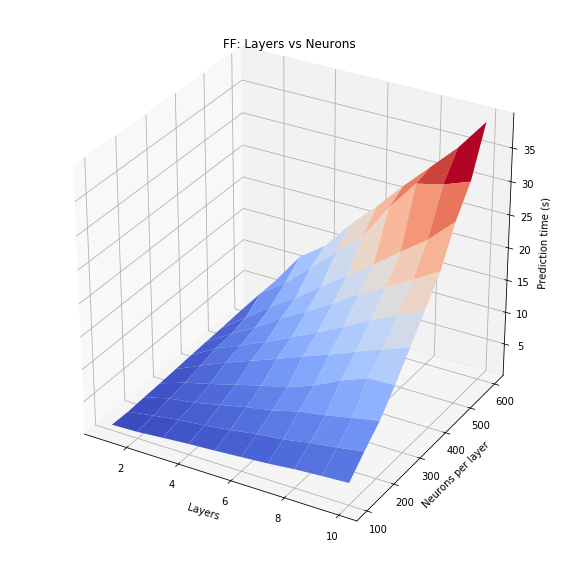

In [9]:
plotTimes("FF: Layers vs Neurons", "Layers", layers, "Neurons per layer", neurons, times)

The graph looks pretty much as you'd expect. The time taken to make a prediction is roughly proportional to the number of layers and the number of neurons per layer.

### Convolutional Networks

Most typical CNNs use a few convolutional hidden layers followed by a few feedforward hidden layers. Since we're only really interested in the characteristics of the convolutional layers, we won't use any feedforward hidden layers.

Similarly to before, we'll vary the number of convolutional hidden layers and number of neurons in each layer (by varying the stride), and also vary the number of filters in each layer.

In [10]:
def buildAndRunCNN(X, numHiddenLayers, stride, numFilters, kernelSize):
    """Builds a CNN and returns the time taken to produce predictions"""

    # Build and run the graph
    tf.reset_default_graph()
    
    with tf.name_scope("inputs"):
        X_in = tf.placeholder(shape=(None, None), dtype=tf.float32, name="X_in")
        X_reshaped = tf.expand_dims(X_in, -1)

    with tf.name_scope("cnn"):
        lastHiddenLayer = None
        for layerNumber in range(numHiddenLayers):
            layerInput = X_reshaped if lastHiddenLayer is None else lastHiddenLayer
            
            lastHiddenLayer = tf.layers.conv1d(layerInput,
                                               filters=numFilters,
                                               kernel_size=kernelSize,
                                               strides=(stride,),
                                               padding="SAME",
                                               activation=tf.nn.relu)
            
            
        logits = tf.layers.dense(lastHiddenLayer, units=1, name="outputs")

    with tf.name_scope("init"):
        init = tf.global_variables_initializer()

    with tf.Session() as sess:
        init.run()

        startTime = time.time()
        logits.eval(feed_dict={X_in: X})
        predictionTime = time.time() - startTime
        
    return predictionTime

In [11]:
# Choose the combinations of number of layers and number of neurons to try out
layers = np.linspace(1, 5, 5, dtype=np.int16)
strides = np.linspace(1, 5, 5, dtype=np.int16)
layers, strides = np.meshgrid(layers, strides)

times = np.zeros((layers.shape))
times = runPredictions(times, buildAndRunCNN, (X, False), (layers, True), (strides, True), (5, False), (3, False))
print(times)

25 / 25
[[  2.92442393   9.63605309  18.60832     21.20478702  28.33186007]
 [  1.52190495   2.28707695   2.70922112   2.94425201   3.1628058 ]
 [  1.18376708   1.47321296   1.57932401   1.62650108   1.64726496]
 [  0.87819695   1.05281591   1.08946395   1.14922404   1.16914797]
 [  0.75695395   0.821491     0.84104395   0.90940499   0.94227695]]


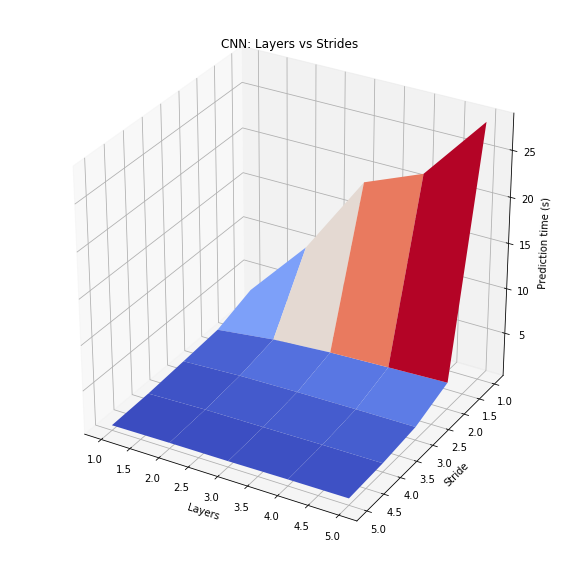

In [12]:
plotTimes("CNN: Layers vs Strides", "Layers", layers, "Stride", strides, times, True)

As expected, a smaller stride and more layers leads to a slower model, though interestingly this only makes a major difference when using an unrealistically small stride (ie. 1). It looks like we might be able to get adequate performance from relatively deep networks as long as we use a reasonable stride (and of course kernel size).

Now we'll fix the stride and vary the number of layers and filters. We'll use a stride of 3, and a maximum of 5 layers.

Anymore layers would be fairly useless as the data will have shrunk enough at each layer that we'll be down to a single neuron by the 4th layer.

Now we'll do the same analysis for layers and filters. 

In [13]:
# Choose the combinations of number of layers and number of filters to try out
layers = np.linspace(1, 5, 5, dtype=np.int16)
filters = np.linspace(1, 10, 10, dtype=np.int16)
layers, filters = np.meshgrid(layers, filters)

times = np.zeros((layers.shape))
times = runPredictions(times, buildAndRunCNN, (X, False), (layers, True), (3, False), (filters, True), (3, False))
print(times)

50 / 50
[[ 0.76289296  0.76571488  0.77364898  0.77106404  0.79751706]
 [ 0.87147403  0.94414306  0.99711394  1.00753808  1.04341912]
 [ 0.93514395  1.08374906  1.121104    1.18781805  1.23194194]
 [ 1.0155549   1.30616498  1.32207704  1.40044188  1.42744398]
 [ 1.12961197  1.43374705  1.54797292  1.61872602  1.65300798]
 [ 1.19780302  1.55146408  1.68825006  1.79891396  1.88812113]
 [ 1.28792     1.76065302  1.92371082  2.027704    2.10342598]
 [ 1.13143492  1.48984194  1.60760808  1.68295217  1.71529794]
 [ 1.31121302  1.83417702  1.98887491  2.11703181  2.20591688]
 [ 1.34315419  1.97599697  2.18729091  2.32729197  2.3869791 ]]


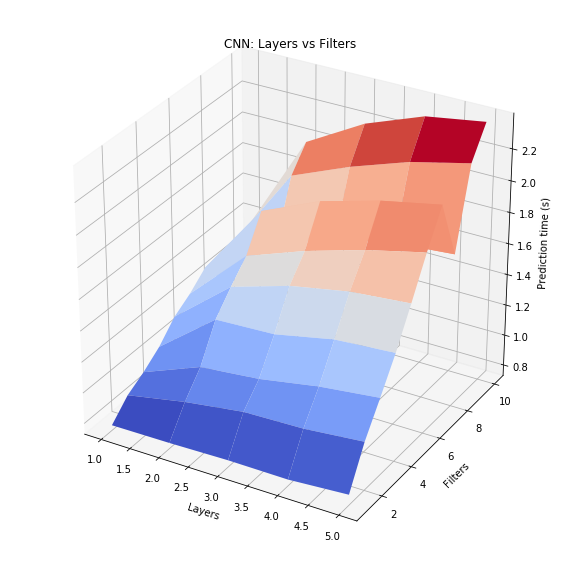

In [14]:
plotTimes("CNN: Layers vs Filters", "Layers", layers, "Filters", filters, times)

We can see that the number of filters has a much larger effect that the number of layers. This makes sense since additional filters mean that each layer will get a little slower, whereas an additional layer is always going to be smaller and therefore faster than the layer upstream of it due to the data shrinking as it passes through the layers before it.

There's a really interesting valley that appears at 8 filters. I'm not sure what might be causing this, but it is consistent and repeatable. Perhaps there is some kind of hardware optimisation which for some reason becomes more effective with 8 filters? This system has 8 virtual cores, so it would be interesting to try this on a different system and see if it still occurs.

### Recurrent Networks

RNNs are basically built specifically for making predictions based on time series data like audio samples, so they should be ideal for this project, right? From my testing they definitely manage to fit the training data very well, but they are also really, really slow to make predictions when compared to other types of networks.

Now we'll repeat our analysis for an RNN.

In [15]:
def buildAndRunRNN(X, numHiddenLayers, numHiddenNeurons):
    """Builds a RNN and returns the time taken to produce predictions"""

    # Build and run the graph
    tf.reset_default_graph()
    
    with tf.name_scope("inputs"):
        X_in = tf.placeholder(shape=(None, None), dtype=tf.float32, name="X_in")
        X_reshaped = tf.expand_dims(X_in, -1)

    # Build the layers
    with tf.name_scope("rnn"):
        rnnCell = tf.nn.rnn_cell.MultiRNNCell(
           [tf.nn.rnn_cell.BasicRNNCell(numHiddenNeurons) for _ in range(numHiddenLayers)]
        )
        rnnOutputs, rnnFinalState = tf.nn.dynamic_rnn(rnnCell,
                                                      X_reshaped,
                                                      dtype=tf.float32,
                                                      time_major=True,
                                                      scope="dynamic_rnn")

        ## Using the final state only:
        logits = tf.layers.dense(rnnFinalState[-1], units=1, name="outputs")

    with tf.name_scope("init"):
        init = tf.global_variables_initializer()

    with tf.Session() as sess:
        init.run()

        startTime = time.time()
        logits.eval(feed_dict={X_in: X})
        predictionTime = time.time() - startTime
        
    return predictionTime

In [16]:
# Choose the combinations of number of layers and number of neurons to try out
layers = np.linspace(1, 5, 5, dtype=np.int16)
neurons = np.linspace(1, 5, 5, dtype=np.int16)
layers, neurons = np.meshgrid(layers, neurons)

times = np.zeros((layers.shape))
times = runPredictions(times, buildAndRunRNN, (X, False), (layers, True), (neurons, True))
print(times)

25 / 25
[[  60.84312487  113.36695194  150.46852207  185.01637697  219.20507312]
 [  45.1605711   112.68710423  151.31077194  185.204211    219.89181018]
 [  43.16181397  112.82975292  151.11470509  185.84423399  219.1423409 ]
 [  38.86211514  113.36271691  151.97420907  186.30813313  220.52522707]
 [  39.68740892  113.04394603  153.27331901  193.34863806  225.93911004]]


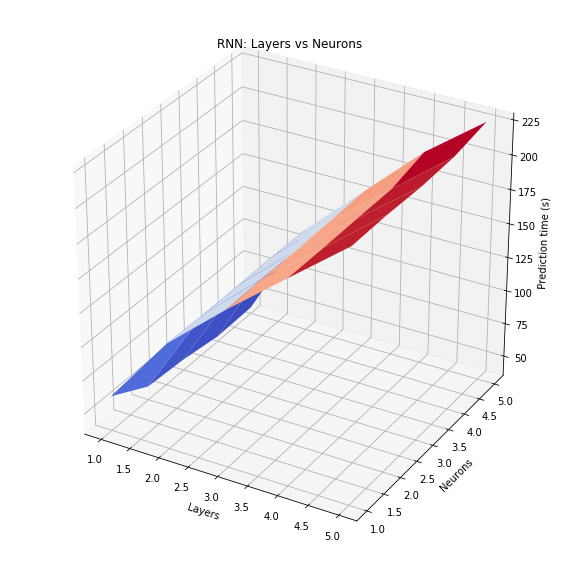

In [17]:
plotTimes("RNN: Layers vs Neurons", "Layers", layers, "Neurons", neurons, times)

Wow, so that's significantly slower than any previous architecture. Again as you would expect, things get significantly slower as more layers and neurons are added.

# To be continued...

There are many other techniques and variables which could potentially be used to improve performance which have not been explored here, and I aim to cover some of these in a future notebook.

These topics may include:
- Data in the time domain vs frequency domain
- Sparse models
- Distillation
- PCA/Autoencoders
